In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import tensorflow
import tensorflow as tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




In [2]:
a=0
b=1
t1,t2,t3,t4=0.2,0.5,0.6,1.0
q2,q4=0.4,1.0
q1_dot,q2_dot,q3_dot,q4_dot=2,0,6,0
T=1.0
cv = 0.6
q0=1
u0=0

geom = dde.geometry.Interval(a,b)
timedomain = dde.geometry.TimeDomain(0,T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [3]:
geomtime.random_points(1000)

array([[0.09698322, 0.09335485],
       [0.691944  , 0.12564626],
       [0.6215069 , 0.14976406],
       ...,
       [0.518171  , 0.6909064 ],
       [0.6673433 , 0.74288523],
       [0.51700944, 0.79659295]], dtype=float32)

In [4]:
def pde(x,y):#第二种设置
    t = x[:, 1:2]
    t1, t2, t3 = tf.constant(0.2), tf.constant(0.5), tf.constant(0.6)
    
    dy_t1 = dde.grad.jacobian(y,x,i=0,j=1)
    dy_zz1 = dde.grad.hessian(y,x,i=0,j=0,component = 0)
    error1 = dy_t1 - cv*dy_zz1 - q2/t1

    dy_t2 = dde.grad.jacobian(y,x,i=1,j=1)
    dy_zz2 = dde.grad.hessian(y,x,i=0,j=0,component = 1)
    error2 = dy_t2 - cv*dy_zz2 

    dy_t3 = dde.grad.jacobian(y,x,i=2,j=1)
    dy_zz3 = dde.grad.hessian(y,x,i=0,j=0,component = 2)
    error3 = dy_t3 - cv*dy_zz3 - (q4-q2)/(t3-t2)

    dy_t4 = dde.grad.jacobian(y,x,i=3,j=1)
    dy_zz4 = dde.grad.hessian(y,x,i=0,j=0,component = 3)
    error4 = dy_t4 - cv*dy_zz4 

    p1, p2, p3, p4 = error1, error2,error3,error4
    
    c1 = tf.where(tf.math.less_equal(t, t1), p1, tf.zeros_like(p1))
    c2 = tf.where(tf.math.logical_and(tf.math.greater(t, t1), tf.math.less_equal(t, t2)), p2, tf.zeros_like(p2))
    c3 = tf.where(tf.math.logical_and(tf.math.greater(t, t2), tf.math.less_equal(t, t3)), p3, tf.zeros_like(p3))
    c4 = tf.where(tf.math.greater(t, t3), p4, tf.zeros_like(p4))
    
    return [c1,c2,c3,c4]

In [5]:
def boundary_t(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_b(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

bc_t1 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_t,component=0)
bc_t2 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_t,component=1)
bc_t3 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_t,component=2)
bc_t4 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_t,component=3)

bc_b1 = dde.icbc.RobinBC(geomtime, lambda x, y: 0, boundary_b,component=0)
bc_b2 = dde.icbc.RobinBC(geomtime, lambda x, y: 0, boundary_b,component=1)
bc_b3 = dde.icbc.RobinBC(geomtime, lambda x, y: 0, boundary_b,component=2)
bc_b4 = dde.icbc.RobinBC(geomtime, lambda x, y: 0, boundary_b,component=3)

ic1 = dde.icbc.IC(geomtime, lambda x: u0, lambda _, on_initial: on_initial,component=0)
ic2 = dde.icbc.IC(geomtime, lambda x: u0, lambda _, on_initial: on_initial,component=1)
ic3 = dde.icbc.IC(geomtime, lambda x: u0, lambda _, on_initial: on_initial,component=2)
ic4 = dde.icbc.IC(geomtime, lambda x: u0, lambda _, on_initial: on_initial,component=3)

xx1, tt1 = np.meshgrid(np.linspace(a, b, 100), [0.2,0.5,0.6])
X1 = np.vstack((np.ravel(xx1), np.ravel(tt1))).T
ob_x1=X1

In [6]:
def interface1(x,_):
    return dde.utils.isclose(x[1], 0.2)

def func1(x, y, X):
    c1 = y[:,0:1] - y[:,1:2]
    
    return c1

def func2(x, y, X):
    dy_z1 = dde.grad.jacobian(y,x,i=0,j=0)
    dy_z2 = dde.grad.jacobian(y,x,i=1,j=0)

    c2 = dy_z1-dy_z2
    return c2


def interface2(x,_):
    return dde.utils.isclose(x[1], 0.5)

def func4(x, y, X):
    c4 = y[:,1:2] - y[:,2:3]
    
    return c4

def func5(x, y, X):
    dy_z2 = dde.grad.jacobian(y,x,i=1,j=0)
    dy_z3 = dde.grad.jacobian(y,x,i=2,j=0)

    c5 = dy_z2-dy_z3
    return c5


def interface3(x,_):
    return dde.utils.isclose(x[1], 0.6)

def func7(x, y, X):
    c7 = y[:,2:3] - y[:,3:4]
    
    return c7

def func8(x, y, X):
    dy_z3 = dde.grad.jacobian(y,x,i=2,j=0)
    dy_z4 = dde.grad.jacobian(y,x,i=3,j=0)

    c8 = dy_z3-dy_z4
    return c8


inter1 = dde.icbc.OperatorBC(geomtime, func1, interface1)
inter2 = dde.icbc.OperatorBC(geomtime, func2, interface1)


inter4 = dde.icbc.OperatorBC(geomtime, func4, interface2)
inter5 = dde.icbc.OperatorBC(geomtime, func5, interface2)


inter7 = dde.icbc.OperatorBC(geomtime, func7, interface3)
inter8 = dde.icbc.OperatorBC(geomtime, func8, interface3)


Compiling model...
Building feed-forward neural network...
'build' took 0.177693 s



d:\ProgramData\Anaconda3\envs\tf5\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 5.060137 s

Training model...

Step      Train loss                                                                                                                                                                                                                      Test loss                                                                                                                                                                                                                       Test metric
0         [1.77e+00, 4.76e-02, 3.72e+00, 2.84e-02, 4.94e-02, 1.32e-01, 2.32e-03, 4.82e-02, 2.25e-03, 9.92e-02, 3.49e-02, 2.15e-02, 1.42e-02, 6.85e-02, 1.04e-01, 2.98e-03, 1.12e-01, 3.84e-01, 1.14e-01, 1.06e+00, 1.41e-01, 9.95e-02]    [1.77e+00, 4.76e-02, 3.72e+00, 2.84e-02, 4.94e-02, 1.32e-01, 2.32e-03, 4.82e-02, 2.25e-03, 9.92e-02, 3.49e-02, 2.15e-02, 1.42e-02, 6.85e-02, 1.04e-01, 2.98e-03, 1.12e-01, 3.84e-01, 1.14e-01, 1.06e+00, 1.41e-01, 9.95e-02]    []  
1000      [4.80e-04, 

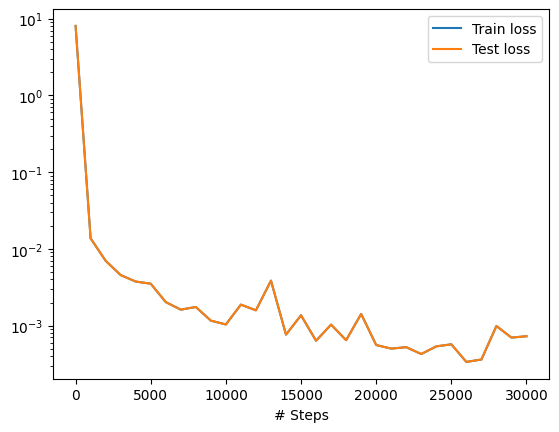

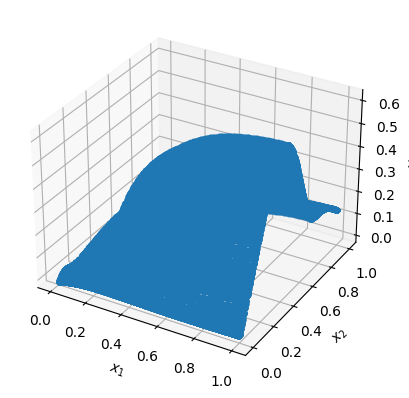

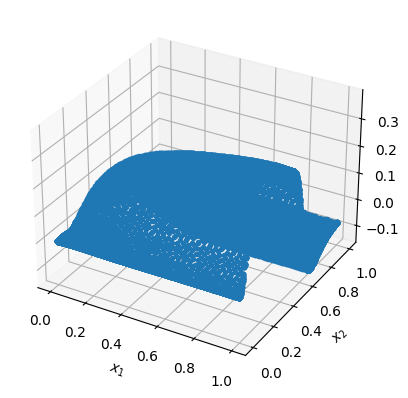

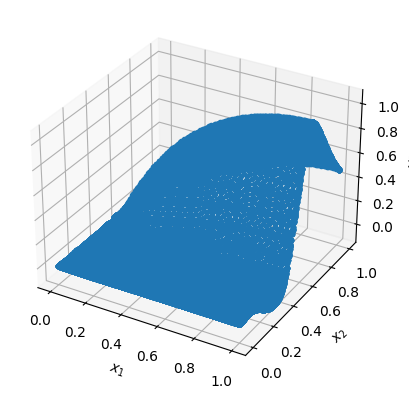

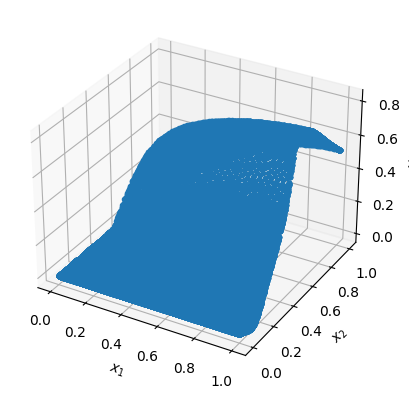

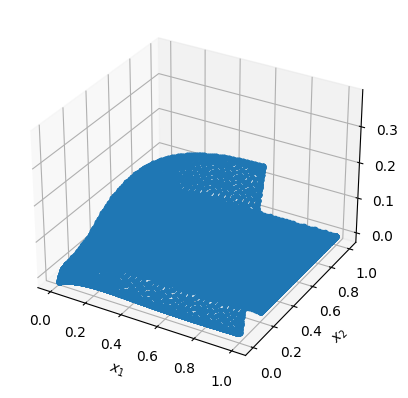

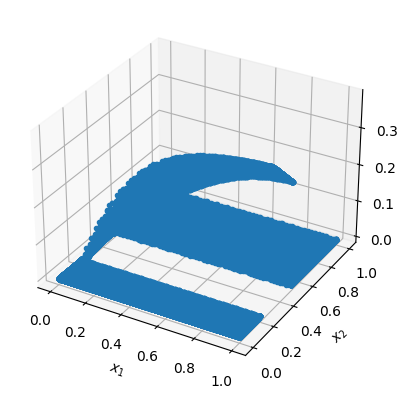

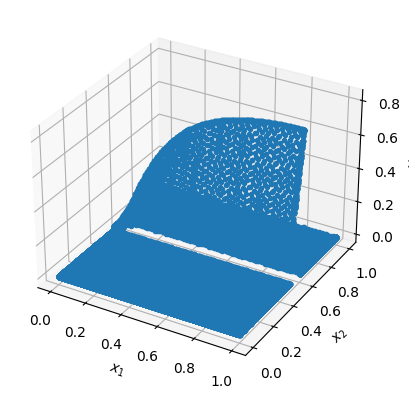

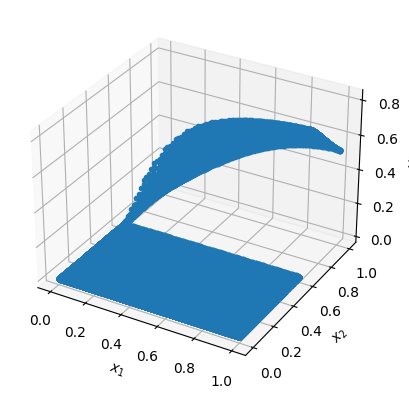

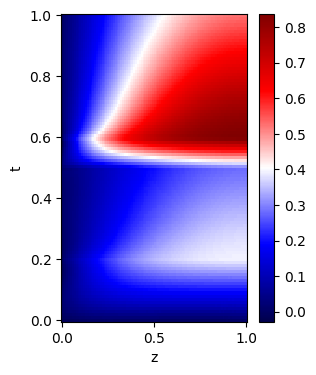

In [7]:
#,inter6,inter9
#num_test=10000
data = dde.data.TimePDE(geomtime,
                        pde,
                        [bc_t1,bc_t2,bc_t3,bc_t4,
                         bc_b1,bc_b2,bc_b3,bc_b4,
                         ic1,ic2,ic3,ic4,
                         inter1,inter2,
                         inter4,inter5,
                         inter7,inter8],
                        num_domain=10000,
                        num_boundary=1000,
                        num_initial=1000,
                        train_distribution='Hammersley', 
                        anchors=ob_x1,
                        )

net = dde.nn.FNN([2] + [30] * 10 + [4], "tanh", "Glorot normal")


def output_transform(inputs, outputs):
    t = inputs[:, 1:2]
    t1, t2, t3 = tf.constant(0.2), tf.constant(0.5), tf.constant(0.6)
    
    p1, p2, p3, p4 = outputs[:, 0:1], outputs[:, 1:2], outputs[:, 2:3], outputs[:, 3:4]
    
    p_cond1 = tf.where(tf.math.less_equal(t, t1), p1, tf.zeros_like(p1))
    p_cond2 = tf.where(tf.math.logical_and(tf.math.greater(t, t1), tf.math.less_equal(t, t2)), p2, tf.zeros_like(p2))
    p_cond3 = tf.where(tf.math.logical_and(tf.math.greater(t, t2), tf.math.less_equal(t, t3)), p3, tf.zeros_like(p3))
    p_cond4 = tf.where(tf.math.greater(t, t3), p4, tf.zeros_like(p4))

    # 删除零元素并堆叠为一列
    #stacked_conditions = tf.stack([p_cond1, p_cond2, p_cond3, p_cond4], axis=0)
    #non_zero_stacked_conditions = tf.boolean_mask(stacked_conditions, tf.math.not_equal(stacked_conditions, 0))
    
    # 转置为列向量
    #reshaped_conditions = tf.expand_dims(non_zero_stacked_conditions, axis=1)
    
    # 按列拼接
    result = tf.concat((p1, p2, p3, p4,p_cond1, p_cond2, p_cond3, p_cond4), axis=1)
    #result = tf.concat((p_cond1, p_cond2, p_cond3, p_cond4), axis=1)
    
    return result

def transfer_c_pre(c_pre):
    p_cond1=c_pre[:,0:1]
    p_cond2=c_pre[:,1:2]
    p_cond3=c_pre[:,2:3]
    p_cond4=c_pre[:,3:4]

    p_cond5=c_pre[:,4:5]
    p_cond6=c_pre[:,5:6]
    p_cond7=c_pre[:,6:7]
    p_cond8=c_pre[:,7:8]
    non_zero_values1 = p_cond5[np.nonzero(p_cond5)]
    non_zero_values2 = p_cond6[np.nonzero(p_cond6)]
    non_zero_values3 = p_cond7[np.nonzero(p_cond7)]
    non_zero_values4 = p_cond8[np.nonzero(p_cond8)]
    values1 = np.reshape(non_zero_values1, (-1, 1))
    values2 = np.reshape(non_zero_values2, (-1, 1))
    values3 = np.reshape(non_zero_values3, (-1, 1))
    values4 = np.reshape(non_zero_values4, (-1, 1))

    result = np.concatenate((values1, values2, values3, values4), axis=0)
    c_pre = result
    return c_pre
    

net.apply_output_transform(output_transform)


model = dde.Model(data,net)

model.compile("adam", lr = 0.001)
#checkpointer = dde.callbacks.ModelCheckpoint("./model61", verbose=1, save_better_only=True)
# display_every=1,
losshistory61, train_state61 = model.train(epochs = 30000,)
dde.saveplot(losshistory61, train_state61, issave=True, isplot=True)

import numpy as np
import matplotlib.pyplot as plt
xx, tt = np.meshgrid(np.linspace(a, b, 100), np.linspace(0, T, 100))
X = np.vstack((np.ravel(xx), np.ravel(tt))).T
y_pre = model.predict(X)
y_pre=transfer_c_pre(y_pre)
y_pre = np.reshape(y_pre, (100, 100)) 

fig = plt.figure(figsize=(3, 4))
plt.pcolor(xx, tt, y_pre, cmap='seismic', shading='auto')
plt.xlabel('z')
plt.ylabel('t')
plt.colorbar()

plt.show()

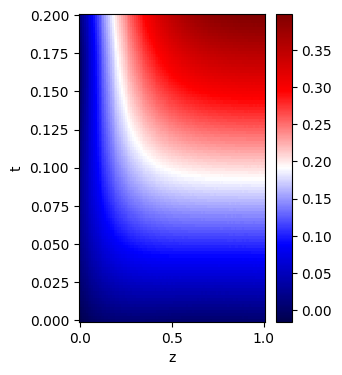

In [13]:
xx, tt = np.meshgrid(np.linspace(a, b, 100), np.linspace(0, 0.2, 100))
X = np.vstack((np.ravel(xx), np.ravel(tt))).T
y_pre = model.predict(X)
y_pre=y_pre[:,0:1]
y_pre = np.reshape(y_pre, (100, 100)) 

fig = plt.figure(figsize=(3, 4))
plt.pcolor(xx, tt, y_pre, cmap='seismic', shading='auto')
plt.xlabel('z')
plt.ylabel('t')
plt.colorbar()

plt.show()

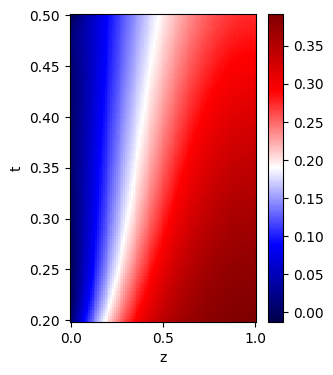

In [14]:
xx, tt = np.meshgrid(np.linspace(a, b, 100), np.linspace(0.2, 0.5, 100))
X = np.vstack((np.ravel(xx), np.ravel(tt))).T
y_pre = model.predict(X)
y_pre=y_pre[:,1:2]
y_pre = np.reshape(y_pre, (100, 100)) 

fig = plt.figure(figsize=(3, 4))
plt.pcolor(xx, tt, y_pre, cmap='seismic', shading='auto')
plt.xlabel('z')
plt.ylabel('t')
plt.colorbar()

plt.show()

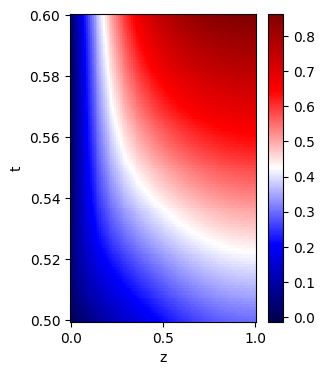

In [15]:
xx, tt = np.meshgrid(np.linspace(a, b, 100), np.linspace(0.5, 0.6, 100))
X = np.vstack((np.ravel(xx), np.ravel(tt))).T
y_pre = model.predict(X)
y_pre=y_pre[:,2:3]
y_pre = np.reshape(y_pre, (100, 100)) 

fig = plt.figure(figsize=(3, 4))
plt.pcolor(xx, tt, y_pre, cmap='seismic', shading='auto')
plt.xlabel('z')
plt.ylabel('t')
plt.colorbar()

plt.show()

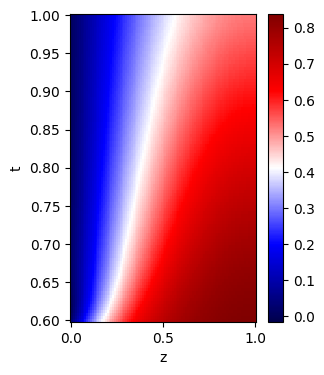

In [16]:
xx, tt = np.meshgrid(np.linspace(a, b, 100), np.linspace(0.6, 1.0, 100))
X = np.vstack((np.ravel(xx), np.ravel(tt))).T
y_pre = model.predict(X)
y_pre=y_pre[:,3:4]
y_pre = np.reshape(y_pre, (100, 100)) 

fig = plt.figure(figsize=(3, 4))
plt.pcolor(xx, tt, y_pre, cmap='seismic', shading='auto')
plt.xlabel('z')
plt.ylabel('t')
plt.colorbar()

plt.show()

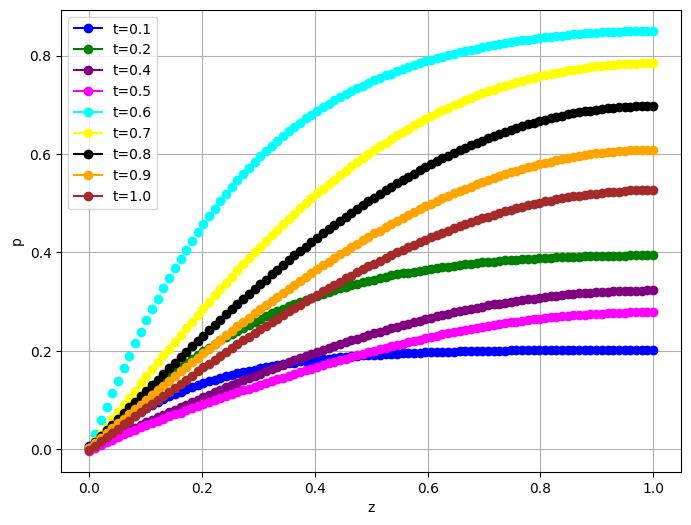

In [8]:
#使用模型预测不同时刻的值
# 预测t=0.1时刻的值
c_pre = model.predict(X)
c_pre=transfer_c_pre(c_pre)
c_pre = np.reshape(c_pre, (100, 100)) 


xx1, tt1 = np.meshgrid(np.linspace(a, b, 100), [0.1])
X1 = np.vstack((np.ravel(xx1), np.ravel(tt1))).T
c_pre1 = model.predict(X1)
c_pre1=transfer_c_pre(c_pre1)
c_pre1 = np.reshape(c_pre1, (1, 100))

# 预测t=0.2时刻的值
xx2, tt2 = np.meshgrid(np.linspace(a, b, 100), [0.2])
X2 = np.vstack((np.ravel(xx2), np.ravel(tt2))).T
c_pre2 = model.predict(X2)
c_pre2=transfer_c_pre(c_pre2)
c_pre2 = np.reshape(c_pre2, (1, 100))

# 预测t=0.3时刻的值
xx3, tt3 = np.meshgrid(np.linspace(a, b, 100), [0.3])
X3 = np.vstack((np.ravel(xx3), np.ravel(tt3))).T
c_pre3 = model.predict(X3)
c_pr3=transfer_c_pre(c_pre3)
#c_pre3 = np.reshape(c_pre3, (1, 100))

# 预测t=0.4时刻的值
xx4, tt4 = np.meshgrid(np.linspace(a, b, 100), [0.4])
X4 = np.vstack((np.ravel(xx4), np.ravel(tt4))).T
c_pre4 = model.predict(X4)
c_pre4=transfer_c_pre(c_pre4)
c_pre4 = np.reshape(c_pre4, (1, 100))

# 预测t=0.5时刻的值
xx5, tt5 = np.meshgrid(np.linspace(a, b, 100), [0.5])
X5 = np.vstack((np.ravel(xx5), np.ravel(tt5))).T
c_pre5 = model.predict(X5)
c_pre5=transfer_c_pre(c_pre5)
c_pre5 = np.reshape(c_pre5, (1, 100))

# 预测t=0.6时刻的值
xx6, tt6 = np.meshgrid(np.linspace(a, b, 100), [0.6])
X6 = np.vstack((np.ravel(xx6), np.ravel(tt6))).T
c_pre6 = model.predict(X6)
c_pre6=transfer_c_pre(c_pre6)
c_pre6 = np.reshape(c_pre6, (1, 100))

# 预测t=0.7时刻的值
xx7, tt7 = np.meshgrid(np.linspace(a, b, 100), [0.7])
X7 = np.vstack((np.ravel(xx7), np.ravel(tt7))).T
c_pre7 = model.predict(X7)
c_pre7=transfer_c_pre(c_pre7)
c_pre7 = np.reshape(c_pre7, (1, 100))

# 预测t=0.8时刻的值
xx8, tt8 = np.meshgrid(np.linspace(a, b, 100), [0.8])
X8 = np.vstack((np.ravel(xx8), np.ravel(tt8))).T
c_pre8 = model.predict(X8)
c_pre8=transfer_c_pre(c_pre8)
c_pre8 = np.reshape(c_pre8, (1, 100))

# 预测t=0.9时刻的值
xx9, tt9 = np.meshgrid(np.linspace(a, b, 100), [0.9])
X9 = np.vstack((np.ravel(xx9), np.ravel(tt9))).T
c_pre9 = model.predict(X9)
c_pre9=transfer_c_pre(c_pre9)
c_pre9 = np.reshape(c_pre9, (1, 100))


# 预测t=1.0时刻的值
xx10, tt10 = np.meshgrid(np.linspace(a, b, 100), [1.0])
X10 = np.vstack((np.ravel(xx10), np.ravel(tt10))).T
c_pre10 = model.predict(X10)
c_pre10=transfer_c_pre(c_pre10)
c_pre10 = np.reshape(c_pre10, (1, 100))

plt.figure(figsize=(8, 6))
plt.plot(xx1, c_pre1, label='_nolegend_', color='blue', marker='o')
plt.plot([], [], label='t=0.1', color='blue', marker='o')  # 添加图例标签
plt.plot(xx2, c_pre2, label='_nolegend_', color='green', marker='o')
plt.plot([], [], label='t=0.2', color='green', marker='o')  # 添加图例标签
#plt.plot(xx3, c_pre3, label='_nolegend_', color='red', marker='o')
#plt.plot([], [], label='t=0.3', color='red', marker='o')  # 添加图例标签
plt.plot(xx4, c_pre4, label='_nolegend_', color='purple', marker='o')
plt.plot([], [], label='t=0.4', color='purple', marker='o')  # 添加图例标签

plt.plot(xx5, c_pre5, label='_nolegend_', color='magenta', marker='o')
plt.plot([], [], label='t=0.5', color='magenta', marker='o') # 添加图例标签
plt.plot(xx6, c_pre6, label='_nolegend_', color='cyan', marker='o')
plt.plot([], [], label='t=0.6', color='cyan', marker='o') # 添加图例标签
plt.plot(xx7, c_pre7, label='_nolegend_', color='yellow', marker='o')
plt.plot([], [], label='t=0.7', color='yellow', marker='o') # 添加图例标签
plt.plot(xx8, c_pre8, label='_nolegend_', color='black', marker='o')
plt.plot([], [], label='t=0.8', color='black', marker='o') # 添加图例标签
plt.plot(xx9, c_pre9, label='_nolegend_', color='orange', marker='o')
plt.plot([], [], label='t=0.9', color='orange', marker='o') # 添加图例标签
plt.plot(xx10, c_pre10, label='_nolegend_', color='brown', marker='o')
plt.plot([], [], label='t=1.0', color='brown', marker='o') # 添加图例标签


plt.xlabel('z')
plt.ylabel('p')
plt.legend()
plt.grid(True)
plt.show()

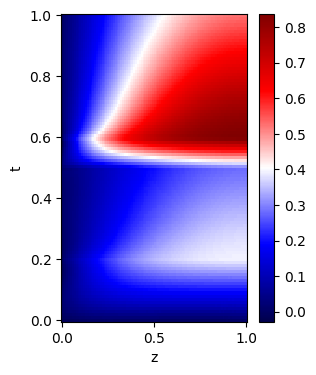

In [9]:
import numpy as np
import matplotlib.pyplot as plt
xx, tt = np.meshgrid(np.linspace(a, b, 100), np.linspace(0, T, 100))
X = np.vstack((np.ravel(xx), np.ravel(tt))).T
c_pre = model.predict(X)
c_pre=transfer_c_pre(c_pre)
c_pre = np.reshape(c_pre, (100, 100)) 

fig = plt.figure(figsize=(3, 4))
plt.pcolor(xx, tt, c_pre, cmap='seismic', shading='auto')
plt.xlabel('z')
plt.ylabel('t')
plt.colorbar()

plt.show()

In [10]:
#解析解
import numpy as np
from scipy.integrate import quad

def calculate_ratio(z, t):
    # 定义公式中的常数和变量
    a=0
    b=1
    t1,t2,t3,t4=0.2,0.5,0.6,1.0
    q1_dot,q2_dot,q3_dot,q4_dot=2,0,6,0
    T=1.0
    cv = 0.6
    q0=1
    u0=0
    h = b - a
    result_sum = 0
    
    for n in range(1, 100):
        M = (2*n-1) * np.pi / 2
        term = (2 / M) * np.sin((M * z) / h)
        if t <= t1:
            result_integral, _ = quad(integrand1, 0, t, args=(M, cv, h, q1_dot,t))
        elif t <= t2:
            result_integral1, _ = quad(integrand1, 0, t1, args=(M, cv, h, q1_dot,t))
            #result_integral2, _ = quad(integrand2, t1, t, args=(M, cv, h, q2_dot))
            result_integral = result_integral1 #+ result_integral2
        elif t <= t3:
            result_integral1, _ = quad(integrand1, 0, t1, args=(M, cv, h, q1_dot,t))
            #result_integral2, _ = quad(integrand2, t1, t2, args=(M, cv, h, q2_dot))
            result_integral3, _ = quad(integrand3, t2, t, args=(M, cv, h, q3_dot,t))
            result_integral = result_integral1  + result_integral3 #+ result_integral2
        else:
            result_integral1, _ = quad(integrand1, 0, t1, args=(M, cv, h, q1_dot,t))
            #result_integral2, _ = quad(integrand2, t1, t2, args=(M, cv, h, q2_dot))
            result_integral3, _ = quad(integrand3, t2, t3, args=(M, cv, h, q3_dot,t))
            #result_integral4, _ = quad(integrand4, t3, t, args=(M, cv, h, q4_dot))
            result_integral = result_integral1  + result_integral3 #+  result_integral2+result_integral4
        
        result_sum += term * result_integral
    
    return result_sum

def integrand1(tau, M, cv, h, q_dot,t):
    return q_dot * np.exp(-M**2 * cv/h**2 * (t-tau))

def integrand2(tau, M, cv, h, q_dot,t):
    return q_dot * np.exp(-M**2 * cv/h**2 * (t-tau))

def integrand3(tau, M, cv, h, q_dot,t):
    return q_dot * np.exp(-M**2 * cv/h**2 * (t-tau))

def integrand4(tau, M, cv, h, q_dot,t):
    return q_dot * np.exp(-M**2 * cv/h**2 * (t-tau))

def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (100, 100)

    # Bounds of 'x' and 't':
    x_min, t_min = (a, 0.0)
    x_max, t_max = (b, T)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = calculate_ratio(x[i], t[j])

    # Save solution:
    np.savez("consolidation1d_top_drained_data", x=x, t=t, usol=usol)
    # Load solution:
    data = np.load("consolidation1d_top_drained_data.npz")

def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("consolidation1d_top_drained_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


In [ ]:
#第二种编法-解析解
import numpy as np
from scipy.integrate import quad

def calculate_ratio(z, t):
    # 定义公式中的常数和变量
    a=0
    b=1
    t1,t2,t3,t4=0.2,0.5,0.6,1.0
    q1_dot,q2_dot,q3_dot,q4_dot=2,0,6,0
    T=1.0
    cv = 0.6
    q0=1
    u0=0
    h = b - a
    result_sum = 0
    
    for n in range(1, 50):
        M = (2*n-1) * np.pi / 2
        term = (2 / M) * np.sin((M * z) / h)* np.exp(-M**2 * cv*t/h**2)
        if t <= t1:
            result_integral, _ = quad(integrand1, 0, t, args=(M, cv, h, q1_dot,t))
        elif t <= t2:
            result_integral1, _ = quad(integrand1, 0, t1, args=(M, cv, h, q1_dot,t))
            result_integral = result_integral1 
        elif t <= t3:
            result_integral1, _ = quad(integrand1, 0, t1, args=(M, cv, h, q1_dot,t))
            result_integral3, _ = quad(integrand3, t2, t, args=(M, cv, h, q3_dot,t))
            result_integral = result_integral1  + result_integral3 
        else:
            result_integral1, _ = quad(integrand1, 0, t1, args=(M, cv, h, q1_dot,t))
            result_integral3, _ = quad(integrand3, t2, t3, args=(M, cv, h, q3_dot,t))
            result_integral = result_integral1  + result_integral3 
        
        result_sum += term * result_integral
    
    return result_sum

def integrand1(tau, M, cv, h, q_dot,t):
    return q_dot * np.exp(M**2 * cv/h**2 * (tau))

def integrand2(tau, M, cv, h, q_dot,t):
    return q_dot * np.exp(M**2 * cv/h**2 * (tau))

def integrand3(tau, M, cv, h, q_dot,t):
    return q_dot * np.exp(M**2 * cv/h**2 * (tau))

def integrand4(tau, M, cv, h, q_dot,t):
    return q_dot * np.exp(M**2 * cv/h**2 * (tau))

def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (100, 100)

    # Bounds of 'x' and 't':
    x_min, t_min = (a, 0.0)
    x_max, t_max = (b, T)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = calculate_ratio(x[i], t[j])

    # Save solution:
    np.savez("2consolidation1d_top_drained_data", x=x, t=t, usol=usol)
    # Load solution:
    data = np.load("2consolidation1d_top_drained_data.npz")

def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("2consolidation1d_top_drained_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y
